## Q1

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext


appName = "Big Data Analytics"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
.set('spark.driver.host','127.0.0.1')\
.setAppName(appName)\
.setMaster(master)

# Create Spark Context 
sc = SparkContext.getOrCreate(conf=conf)

# Create SQL Context to conduct some database operations
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder\
.config("spark.jars.packages", "org.postgresql:postgresql:42.2.29") \
.config("spark.sql.execution.arrow.enabled","true")\
.getOrCreate() 

24/10/03 19:06:14 WARN Utils: Your hostname, Kitiyas-MacBook-Air-5.local resolves to a loopback address: 127.0.0.1; using 10.0.0.134 instead (on interface en0)
24/10/03 19:06:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/03 19:06:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/10/03 19:06:16 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/03 19:06:16 WARN SparkSession: Using an existing Spark session; only runtime S

In [3]:
# Column names
col_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "classes",
    "difficulty_level"]
print(len(col_names))

43


In [4]:
# Read the train dataset
sparkDF = spark.read.csv("./NSL-KDD/KDDTrain+.txt",header=False, inferSchema= True).toDF(*col_names)

24/09/30 21:30:27 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [5]:
sparkDF.show()

+--------+-------------+----------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----------+----------------+
|duration|protocol_type|   service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate

24/09/30 21:30:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
# Query the count of each protocol_type for non-logged in users
print("Non-logged in users: ")
sparkDF.filter(sparkDF.logged_in == 0).groupBy("protocol_type").count().show()

Non-logged in users: 
+-------------+-----+
|protocol_type|count|
+-------------+-----+
|          tcp|52837|
|          udp|14993|
|         icmp| 8291|
+-------------+-----+



In [7]:
# Query the count of each protocol_type for logged in users
print("Logged in users: ")
sparkDF.filter(sparkDF.logged_in > 0).groupBy("protocol_type").count().show()

Logged in users: 
+-------------+-----+
|protocol_type|count|
+-------------+-----+
|          tcp|49852|
+-------------+-----+



## Q2

In [8]:
# Create a new data frame that includes all network traffic with normal traffic
sparkDF_normal_traffic = sparkDF.filter(sparkDF.classes == 'normal')
sparkDF_normal_traffic.show()

+--------+-------------+--------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+----------------+
|duration|protocol_type| service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_dif

In [9]:
from pyspark.sql.functions import *

# Override the protocol_type to be “tcp” for all
protocol_value = "tcp"
sparkDF_all_normal_traffic = (sparkDF_normal_traffic\
    .withColumn('protocol_type',when(sparkDF_normal_traffic.protocol_type != protocol_value,\
                    regexp_replace(sparkDF_normal_traffic.protocol_type,sparkDF_normal_traffic.protocol_type, protocol_value)) \
                    .otherwise(sparkDF_normal_traffic.protocol_type))\
                )

sparkDF_all_normal_traffic.show()

+--------+-------------+--------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+----------------+
|duration|protocol_type| service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_dif

In [10]:
# Check the overided protocol_type
sparkDF_all_normal_traffic.groupBy("protocol_type").count().show()

+-------------+-----+
|protocol_type|count|
+-------------+-----+
|          tcp|67343|
+-------------+-----+



## Q3

Refer to q3_1.png and q3_2.png

## Q4

In [11]:
# Read the train dataset
trainDF = sparkDF
trainDF_with_data_type = trainDF.withColumn("data_type",lit('train'))
trainDF_with_data_type.show(1, vertical=True)

-RECORD 0-------------------------------
 duration                    | 0        
 protocol_type               | tcp      
 service                     | ftp_data 
 flag                        | SF       
 src_bytes                   | 491      
 dst_bytes                   | 0        
 land                        | 0        
 wrong_fragment              | 0        
 urgent                      | 0        
 hot                         | 0        
 num_failed_logins           | 0        
 logged_in                   | 0        
 num_compromised             | 0        
 root_shell                  | 0        
 su_attempted                | 0        
 num_root                    | 0        
 num_file_creations          | 0        
 num_shells                  | 0        
 num_access_files            | 0        
 num_outbound_cmds           | 0        
 is_host_login               | 0        
 is_guest_login              | 0        
 count                       | 2        
 srv_count      

In [12]:
# Read the test dataset
testDF = spark.read.csv("./NSL-KDD/KDDTest+.txt",header=False, inferSchema= True).toDF(*col_names)
testDF_with_data_type = testDF.withColumn("data_type",lit('test'))
testDF_with_data_type.show(1, vertical=True)

-RECORD 0------------------------------
 duration                    | 0       
 protocol_type               | tcp     
 service                     | private 
 flag                        | REJ     
 src_bytes                   | 0       
 dst_bytes                   | 0       
 land                        | 0       
 wrong_fragment              | 0       
 urgent                      | 0       
 hot                         | 0       
 num_failed_logins           | 0       
 logged_in                   | 0       
 num_compromised             | 0       
 root_shell                  | 0       
 su_attempted                | 0       
 num_root                    | 0       
 num_file_creations          | 0       
 num_shells                  | 0       
 num_access_files            | 0       
 num_outbound_cmds           | 0       
 is_host_login               | 0       
 is_guest_login              | 0       
 count                       | 229     
 srv_count                   | 10      


24/09/30 21:30:29 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [13]:
# Combine train and test 
datasetDF = trainDF_with_data_type.union(testDF_with_data_type)
datasetDF.groupBy("data_type").count().show()

+---------+------+
|data_type| count|
+---------+------+
|    train|125973|
|     test| 22544|
+---------+------+



In [14]:
# Ingest dataset into Postgres table
db_properties={}
db_properties['username']="postgres"
db_properties['password']=""
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "NSLKDD"


datasetDF.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()


In [15]:
# Test that the db has dataset
jdbcDF = spark.read \
    .format("jdbc") \
    .option("url", db_properties['url']) \
    .option("dbtable", db_properties['table']) \
    .option("user", db_properties['username']) \
    .option("password", db_properties['password']) \
    .option("driver", db_properties['driver']) \
    .load()

jdbcDF.show()

+--------+-------------+----------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----------+----------------+---------+
|duration|protocol_type|   service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|dif

In [16]:
jdbcDF.groupBy("data_type").count().show()

+---------+------+
|data_type| count|
+---------+------+
|    train|125973|
|     test| 22544|
+---------+------+



## Q5

#### Phase-I

In [3]:
# Ingest data
col_names = [
    "game_id",
    "play_id",
    "quarter",
    "game_clock",
    "down",
    "yards_to_go",
    "possession_team",
    "yardline_side",
    "yardline_number",
    "offense_formation",
    "personnel_offense",
    "defenders_in_the_box",
    "number_of_pass_rushers",
    "personnel_defense",
    "home_score_before_play",
    "visitor_score_before_play",
    "home_score_after_play",
    "visitor_score_after_play",
    "is_penalty",
    "is_ST_play",
    "special_teams_play_type",
    "kick_return_yardage",
    "pass_length",
    "pass_result",
    "yards_after_catch",
    "play_result",
    "play_description"]

df = spark.read.csv("./plays.csv",header=True, inferSchema=True).toDF(*col_names)

24/10/03 19:06:22 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [4]:
df.show()

+----------+-------+-------+-------------------+----+-----------+---------------+-------------+---------------+-----------------+-----------------+--------------------+----------------------+-----------------+----------------------+-------------------------+---------------------+------------------------+----------+----------+-----------------------+-------------------+-----------+-----------+-----------------+-----------+--------------------+
|   game_id|play_id|quarter|         game_clock|down|yards_to_go|possession_team|yardline_side|yardline_number|offense_formation|personnel_offense|defenders_in_the_box|number_of_pass_rushers|personnel_defense|home_score_before_play|visitor_score_before_play|home_score_after_play|visitor_score_after_play|is_penalty|is_ST_play|special_teams_play_type|kick_return_yardage|pass_length|pass_result|yards_after_catch|play_result|    play_description|
+----------+-------+-------+-------------------+----+-----------+---------------+-------------+-----------

24/10/03 19:06:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
df.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- play_id: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- game_clock: timestamp (nullable = true)
 |-- down: integer (nullable = true)
 |-- yards_to_go: integer (nullable = true)
 |-- possession_team: string (nullable = true)
 |-- yardline_side: string (nullable = true)
 |-- yardline_number: string (nullable = true)
 |-- offense_formation: string (nullable = true)
 |-- personnel_offense: string (nullable = true)
 |-- defenders_in_the_box: string (nullable = true)
 |-- number_of_pass_rushers: string (nullable = true)
 |-- personnel_defense: string (nullable = true)
 |-- home_score_before_play: integer (nullable = true)
 |-- visitor_score_before_play: integer (nullable = true)
 |-- home_score_after_play: integer (nullable = true)
 |-- visitor_score_after_play: integer (nullable = true)
 |-- is_penalty: boolean (nullable = true)
 |-- is_ST_play: boolean (nullable = true)
 |-- special_teams_play_type: string (nullable 

In [6]:
df.describe().show()

+-------+--------------------+------------------+------------------+------------------+-----------------+---------------+-------------+------------------+-----------------+-----------------+--------------------+----------------------+--------------------+----------------------+-------------------------+---------------------+------------------------+-----------------------+-------------------+------------------+-----------+-----------------+------------------+--------------------+
|summary|             game_id|           play_id|           quarter|              down|      yards_to_go|possession_team|yardline_side|   yardline_number|offense_formation|personnel_offense|defenders_in_the_box|number_of_pass_rushers|   personnel_defense|home_score_before_play|visitor_score_before_play|home_score_after_play|visitor_score_after_play|special_teams_play_type|kick_return_yardage|       pass_length|pass_result|yards_after_catch|       play_result|    play_description|
+-------+--------------------+

#### Casting column data types

**Column that need to cast type**

- yards_after_catch -> to_number

- pass_length -> to_number

- kick_return_yardage -> to_number

- number_of_pass_rushers -> to_number

- defenders_in_the_box -> to_number

- yardline_number -> to_number

In [7]:
from pyspark.sql.functions import *
# Casting game_clock column to string
casted_types_df = (df.withColumn("game_clock_string", df["game_clock"] \
                    .cast("string")).drop("game_clock") 
           )
# Casting yards_after_catch column to double
casted_types_df = (casted_types_df.withColumn("yards_after_catch_numerical", casted_types_df["yards_after_catch"] \
                    .cast("double")).drop("yards_after_catch") 
           )
casted_types_df = casted_types_df.withColumnRenamed("yards_after_catch_numerical","yards_after_catch")

# Casting pass_length column to integer
casted_types_df = (casted_types_df.withColumn("pass_length_numerical", casted_types_df["pass_length"] \
                    .cast("integer")).drop("pass_length") 
           )
casted_types_df = casted_types_df.withColumnRenamed("pass_length_numerical","pass_length")

# Casting kick_return_yardage column to integer
casted_types_df = (casted_types_df.withColumn("kick_return_yardage_numerical", casted_types_df["kick_return_yardage"] \
                    .cast("integer")).drop("kick_return_yardage") 
           )
casted_types_df = casted_types_df.withColumnRenamed("kick_return_yardage_numerical","kick_return_yardage")

# Casting number_of_pass_rushers column to double
casted_types_df = (casted_types_df.withColumn("number_of_pass_rushers_numerical", casted_types_df["number_of_pass_rushers"] \
                    .cast("double")).drop("number_of_pass_rushers") 
           )
casted_types_df = casted_types_df.withColumnRenamed("number_of_pass_rushers_numerical","number_of_pass_rushers")

# Casting defenders_in_the_box column to integer
casted_types_df = (casted_types_df.withColumn("defenders_in_the_box_numerical", casted_types_df["defenders_in_the_box"] \
                    .cast("integer")).drop("defenders_in_the_box") 
           )
casted_types_df = casted_types_df.withColumnRenamed("defenders_in_the_box_numerical","defenders_in_the_box")

# Casting yardline_number column to integer
casted_types_df = (casted_types_df.withColumn("yardline_number_numerical", casted_types_df["yardline_number"] \
                    .cast("integer")).drop("yardline_number") 
           )
casted_types_df = casted_types_df.withColumnRenamed("yardline_number_numerical","yardline_number")


casted_types_df.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- play_id: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- down: integer (nullable = true)
 |-- yards_to_go: integer (nullable = true)
 |-- possession_team: string (nullable = true)
 |-- yardline_side: string (nullable = true)
 |-- offense_formation: string (nullable = true)
 |-- personnel_offense: string (nullable = true)
 |-- personnel_defense: string (nullable = true)
 |-- home_score_before_play: integer (nullable = true)
 |-- visitor_score_before_play: integer (nullable = true)
 |-- home_score_after_play: integer (nullable = true)
 |-- visitor_score_after_play: integer (nullable = true)
 |-- is_penalty: boolean (nullable = true)
 |-- is_ST_play: boolean (nullable = true)
 |-- special_teams_play_type: string (nullable = true)
 |-- pass_result: string (nullable = true)
 |-- play_result: integer (nullable = true)
 |-- play_description: string (nullable = true)
 |-- game_clock_string: string (nullable = true)
 |-- y

#### Handling Missing Values

In [8]:
# Check NULL values
total_rows = casted_types_df.count() # Total number of rows in the DataFrame
print("Total ")
null_counts_plays_df = casted_types_df.select([(count(when(col(c).isNull(), c)) / total_rows).alias(c) \
                        for c in casted_types_df.columns])

null_counts_plays_df.show(truncate=False, vertical=True)

Total 
-RECORD 0-----------------------------------------
 game_id                   | 0.0                  
 play_id                   | 0.0                  
 quarter                   | 0.0                  
 down                      | 0.0                  
 yards_to_go               | 0.0                  
 possession_team           | 0.0                  
 yardline_side             | 0.0                  
 offense_formation         | 0.0                  
 personnel_offense         | 0.0                  
 personnel_defense         | 0.0                  
 home_score_before_play    | 0.0                  
 visitor_score_before_play | 0.0                  
 home_score_after_play     | 0.0                  
 visitor_score_after_play  | 0.0                  
 is_penalty                | 0.0                  
 is_ST_play                | 0.0                  
 special_teams_play_type   | 0.0                  
 pass_result               | 0.0                  
 play_result            

In [9]:
# Drop the column that contain NULL more than 50%
# yards_after_catch is importance feature -> imputation
# pass_length is not importace feature -> drop
# kick_return_yardage has significantly miss data -> drop
# number_of_pass_rushers is importance feature -> imputation

casted_types_df_with_na_dropped_column = casted_types_df.drop("pass_length")
casted_types_df_with_na_dropped_column = casted_types_df_with_na_dropped_column.drop("kick_return_yardage")
casted_types_df_with_na_dropped_column.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- play_id: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- down: integer (nullable = true)
 |-- yards_to_go: integer (nullable = true)
 |-- possession_team: string (nullable = true)
 |-- yardline_side: string (nullable = true)
 |-- offense_formation: string (nullable = true)
 |-- personnel_offense: string (nullable = true)
 |-- personnel_defense: string (nullable = true)
 |-- home_score_before_play: integer (nullable = true)
 |-- visitor_score_before_play: integer (nullable = true)
 |-- home_score_after_play: integer (nullable = true)
 |-- visitor_score_after_play: integer (nullable = true)
 |-- is_penalty: boolean (nullable = true)
 |-- is_ST_play: boolean (nullable = true)
 |-- special_teams_play_type: string (nullable = true)
 |-- pass_result: string (nullable = true)
 |-- play_result: integer (nullable = true)
 |-- play_description: string (nullable = true)
 |-- game_clock_string: string (nullable = true)
 |-- y

In [10]:
# Drop the row that contain NULL 
# defenders_in_the_box 
# yardline_number
casted_types_df_with_na_dropped_rows = casted_types_df_with_na_dropped_column.na.drop(subset=["defenders_in_the_box","yardline_number"])
casted_types_df_with_na_dropped_rows.count()


11391

In [11]:
from pyspark.ml.feature import Imputer

columns_to_be_imputed = ["yards_after_catch","number_of_pass_rushers"]
# Create new columns with imputed values. New columns will be suffixed with "_imputed"
imputer = Imputer (
            inputCols=columns_to_be_imputed,
            outputCols=["{}_imputed".format(c) for c in columns_to_be_imputed])\
            .setStrategy("median")

df_imputed = imputer.fit(casted_types_df_with_na_dropped_rows).transform(casted_types_df_with_na_dropped_rows)

24/10/03 19:06:26 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [12]:
# we will drop the old column without imputation. We have only one column to be imputed
df_imputed_enhanced = df_imputed.drop(columns_to_be_imputed[0])
df_fully_imputed = df_imputed_enhanced.withColumnRenamed("yards_after_catch_imputed","yards_after_catch")
df_fully_imputed.show(1, vertical=True)

-RECORD 0----------------------------------------------
 game_id                        | 2017091004           
 play_id                        | 73                   
 quarter                        | 1                    
 down                           | 1                    
 yards_to_go                    | 10                   
 possession_team                | ARI                  
 yardline_side                  | ARI                  
 offense_formation              | SHOTGUN              
 personnel_offense              | 1 RB, 1 TE, 3 WR     
 personnel_defense              | 4 DL, 2 LB, 5 DB     
 home_score_before_play         | 0                    
 visitor_score_before_play      | 0                    
 home_score_after_play          | 0                    
 visitor_score_after_play       | 0                    
 is_penalty                     | false                
 is_ST_play                     | false                
 special_teams_play_type        | NA            

In [13]:
df_imputed_enhanced = df_fully_imputed.drop(columns_to_be_imputed[1])
df_fully_imputed = df_imputed_enhanced.withColumnRenamed("number_of_pass_rushers_imputed","number_of_pass_rushers")
df_fully_imputed.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- play_id: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- down: integer (nullable = true)
 |-- yards_to_go: integer (nullable = true)
 |-- possession_team: string (nullable = true)
 |-- yardline_side: string (nullable = true)
 |-- offense_formation: string (nullable = true)
 |-- personnel_offense: string (nullable = true)
 |-- personnel_defense: string (nullable = true)
 |-- home_score_before_play: integer (nullable = true)
 |-- visitor_score_before_play: integer (nullable = true)
 |-- home_score_after_play: integer (nullable = true)
 |-- visitor_score_after_play: integer (nullable = true)
 |-- is_penalty: boolean (nullable = true)
 |-- is_ST_play: boolean (nullable = true)
 |-- special_teams_play_type: string (nullable = true)
 |-- pass_result: string (nullable = true)
 |-- play_result: integer (nullable = true)
 |-- play_description: string (nullable = true)
 |-- game_clock_string: string (nullable = true)
 |-- d

In [14]:
# Check NA values

# Calculate the percent of 'NA' values for dropping column(s)
na_counts = df_fully_imputed.select([
    (count(when(col(c) == 'NA', c)) / total_rows * 100).alias(c) for c in df_fully_imputed.columns
])
# Show the counts of 'NA' values for each column
na_counts.show(truncate=False, vertical=True)

-RECORD 0---------------------------------------
 game_id                   | 0.0                
 play_id                   | 0.0                
 quarter                   | 0.0                
 down                      | 0.0                
 yards_to_go               | 0.0                
 possession_team           | 0.0                
 yardline_side             | 0.0                
 offense_formation         | 0.9441273867399421 
 personnel_offense         | 0.0                
 personnel_defense         | 0.0                
 home_score_before_play    | 0.0                
 visitor_score_before_play | 0.0                
 home_score_after_play     | 0.0                
 visitor_score_after_play  | 0.0                
 is_penalty                | 0.0                
 is_ST_play                | 0.0                
 special_teams_play_type   | 80.25082787289509  
 pass_result               | 32.00873670119073  
 play_result               | 0.0                
 play_description   

In [15]:
# Drop the column that contain NA more than 50%
# special_teams_play_type
df_with_na_dropped_column = df_fully_imputed.drop("special_teams_play_type")
df_with_na_dropped_column.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- play_id: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- down: integer (nullable = true)
 |-- yards_to_go: integer (nullable = true)
 |-- possession_team: string (nullable = true)
 |-- yardline_side: string (nullable = true)
 |-- offense_formation: string (nullable = true)
 |-- personnel_offense: string (nullable = true)
 |-- personnel_defense: string (nullable = true)
 |-- home_score_before_play: integer (nullable = true)
 |-- visitor_score_before_play: integer (nullable = true)
 |-- home_score_after_play: integer (nullable = true)
 |-- visitor_score_after_play: integer (nullable = true)
 |-- is_penalty: boolean (nullable = true)
 |-- is_ST_play: boolean (nullable = true)
 |-- pass_result: string (nullable = true)
 |-- play_result: integer (nullable = true)
 |-- play_description: string (nullable = true)
 |-- game_clock_string: string (nullable = true)
 |-- defenders_in_the_box: integer (nullable = true)
 |-- yar

In [16]:
# Handle "pass_result" columns with filling missing data with a value that can't be present in the dataset
print("pass_result before:")
df_with_na_dropped_column.select("pass_result").groupBy("pass_result").count().show()

value_not_in_dataset = 'IN'
# Replace None/Missing Value with a value that can't be present in the dataset.
df_with_filled_na = (df_with_na_dropped_column.withColumn("pass_result", \
                when(casted_types_df_with_na_dropped_rows.pass_result=='NA',\
                    value_not_in_dataset) \
                .otherwise(casted_types_df_with_na_dropped_rows.pass_result))\
                )
# df_with_na_dropped_column.select("pass_result").na.replace("NA", value_not_in_dataset)
print("pass_result after:")
df_with_filled_na.select("pass_result").groupBy("pass_result").count().show()


pass_result before:
+-----------+-----+
|pass_result|count|
+-----------+-----+
|         NA| 4543|
|          C| 3869|
|         IN|  154|
|          S|  444|
|          R|  248|
|          I| 2133|
+-----------+-----+

pass_result after:
+-----------+-----+
|pass_result|count|
+-----------+-----+
|          C| 3869|
|         IN| 4697|
|          S|  444|
|          R|  248|
|          I| 2133|
+-----------+-----+



#### Clean up data

In [17]:
# Drop the columns that not in the plays.csv description
clean_df = df_with_filled_na.drop("offense_formation")
clean_df = clean_df.drop("possession_team")

# # Drop the columns that is just a detail
clean_df =  clean_df.drop("play_description")
clean_df = clean_df.drop("game_clock_string")

clean_df.printSchema()
print("Total dataset: ", clean_df.count())

root
 |-- game_id: integer (nullable = true)
 |-- play_id: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- down: integer (nullable = true)
 |-- yards_to_go: integer (nullable = true)
 |-- yardline_side: string (nullable = true)
 |-- personnel_offense: string (nullable = true)
 |-- personnel_defense: string (nullable = true)
 |-- home_score_before_play: integer (nullable = true)
 |-- visitor_score_before_play: integer (nullable = true)
 |-- home_score_after_play: integer (nullable = true)
 |-- visitor_score_after_play: integer (nullable = true)
 |-- is_penalty: boolean (nullable = true)
 |-- is_ST_play: boolean (nullable = true)
 |-- pass_result: string (nullable = true)
 |-- play_result: integer (nullable = true)
 |-- defenders_in_the_box: integer (nullable = true)
 |-- yardline_number: integer (nullable = true)
 |-- yards_after_catch: double (nullable = true)
 |-- number_of_pass_rushers: double (nullable = true)

Total dataset:  11391


In [18]:
# Store dataset into Postgres table
db_properties={}
db_properties['username']="postgres"
db_properties['password']=""
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "players"

# Write data into the db
clean_df.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

In [19]:
# Test that the db has dataset
postgresDF = spark.read \
    .format("jdbc") \
    .option("url", db_properties['url']) \
    .option("dbtable", db_properties['table']) \
    .option("user", db_properties['username']) \
    .option("password", db_properties['password']) \
    .option("driver", db_properties['driver']) \
    .load()

postgresDF.show()

+----------+-------+-------+----+-----------+-------------+-----------------+-----------------+----------------------+-------------------------+---------------------+------------------------+----------+----------+-----------+-----------+--------------------+---------------+-----------------+----------------------+
|   game_id|play_id|quarter|down|yards_to_go|yardline_side|personnel_offense|personnel_defense|home_score_before_play|visitor_score_before_play|home_score_after_play|visitor_score_after_play|is_penalty|is_ST_play|pass_result|play_result|defenders_in_the_box|yardline_number|yards_after_catch|number_of_pass_rushers|
+----------+-------+-------+----+-----------+-------------+-----------------+-----------------+----------------------+-------------------------+---------------------+------------------------+----------+----------+-----------+-----------+--------------------+---------------+-----------------+----------------------+
|2017091004|     73|      1|   1|         10|       

### Phase-II

In [20]:
# Summary table
postgresDF.summary().show(truncate=False, vertical=True)

-RECORD 0-------------------------------------------
 summary                   | count                  
 game_id                   | 11391                  
 play_id                   | 11391                  
 quarter                   | 11391                  
 down                      | 11391                  
 yards_to_go               | 11391                  
 yardline_side             | 11391                  
 personnel_offense         | 11391                  
 personnel_defense         | 11391                  
 home_score_before_play    | 11391                  
 visitor_score_before_play | 11391                  
 home_score_after_play     | 11391                  
 visitor_score_after_play  | 11391                  
 pass_result               | 11391                  
 play_result               | 11391                  
 defenders_in_the_box      | 11391                  
 yardline_number           | 11391                  
 yards_after_catch         | 11391            

In [21]:
# We will draw boxplots for the numerical features
# Now let's check the datatypes of the dataframe
postgresDF.dtypes

[('game_id', 'int'),
 ('play_id', 'int'),
 ('quarter', 'int'),
 ('down', 'int'),
 ('yards_to_go', 'int'),
 ('yardline_side', 'string'),
 ('personnel_offense', 'string'),
 ('personnel_defense', 'string'),
 ('home_score_before_play', 'int'),
 ('visitor_score_before_play', 'int'),
 ('home_score_after_play', 'int'),
 ('visitor_score_after_play', 'int'),
 ('is_penalty', 'boolean'),
 ('is_ST_play', 'boolean'),
 ('pass_result', 'string'),
 ('play_result', 'int'),
 ('defenders_in_the_box', 'int'),
 ('yardline_number', 'int'),
 ('yards_after_catch', 'double'),
 ('number_of_pass_rushers', 'double')]

#### Blockplots

In [23]:
numeric_features = [feature[0] for feature in postgresDF.dtypes if feature[1] in ('int','double')]
numeric_features

['game_id',
 'play_id',
 'quarter',
 'down',
 'yards_to_go',
 'home_score_before_play',
 'visitor_score_before_play',
 'home_score_after_play',
 'visitor_score_after_play',
 'play_result',
 'defenders_in_the_box',
 'yardline_number',
 'yards_after_catch',
 'number_of_pass_rushers']

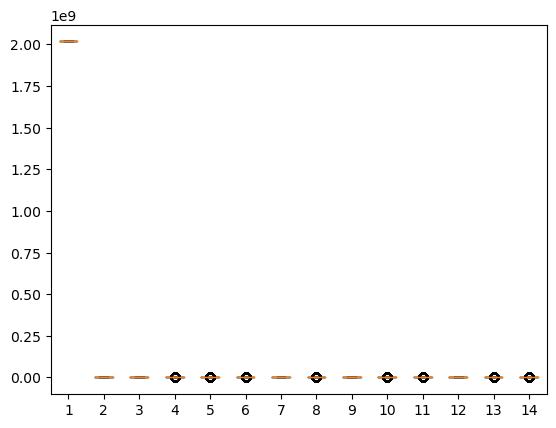

In [24]:
import matplotlib.pyplot as plt

#Extract data and convert them into Pandas for visualization
converted_data = postgresDF[numeric_features].toPandas()

figure = plt.boxplot(converted_data)

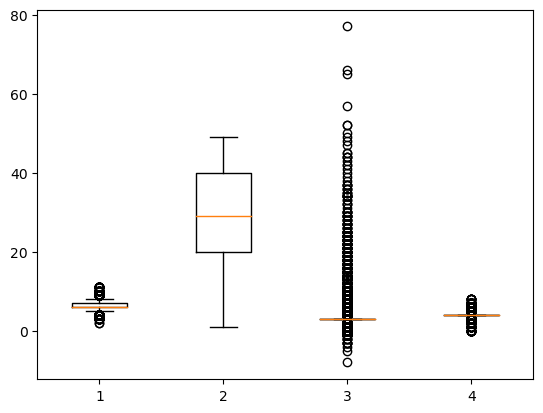

In [25]:
spotted_data = postgresDF[numeric_features[10:14]].toPandas()
figure_subset = plt.boxplot(spotted_data)

**Outliers**

In [28]:
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [29]:
# As a reminder, we don't have any null values for the outliers to be handled
postgresDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_features])

DataFrame[game_id: bigint, play_id: bigint, quarter: bigint, down: bigint, yards_to_go: bigint, home_score_before_play: bigint, visitor_score_before_play: bigint, home_score_after_play: bigint, visitor_score_after_play: bigint, play_result: bigint, defenders_in_the_box: bigint, yardline_number: bigint, yards_after_catch: bigint, number_of_pass_rushers: bigint]

In [30]:
postgresDF.show(1, vertical=True)

-RECORD 0-------------------------------------
 game_id                   | 2017091004       
 play_id                   | 73               
 quarter                   | 1                
 down                      | 1                
 yards_to_go               | 10               
 yardline_side             | ARI              
 personnel_offense         | 1 RB, 1 TE, 3 WR 
 personnel_defense         | 4 DL, 2 LB, 5 DB 
 home_score_before_play    | 0                
 visitor_score_before_play | 0                
 home_score_after_play     | 0                
 visitor_score_after_play  | 0                
 is_penalty                | false            
 is_ST_play                | false            
 pass_result               | C                
 play_result               | 4                
 defenders_in_the_box      | 6                
 yardline_number           | 23               
 yards_after_catch         | 6.0              
 number_of_pass_rushers    | 4.0              
only showing 

In [31]:
df_with_outlier_handling = find_outliers(postgresDF)
df_with_outlier_handling.show(1, vertical=True)

24/10/02 15:52:41 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/02 15:52:41 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/02 15:52:41 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/02 15:52:41 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/02 15:52:41 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

-RECORD 0-------------------------------------
 game_id                   | 2017091004       
 play_id                   | 73               
 quarter                   | 1                
 down                      | 1                
 yards_to_go               | 10               
 yardline_side             | ARI              
 personnel_offense         | 1 RB, 1 TE, 3 WR 
 personnel_defense         | 4 DL, 2 LB, 5 DB 
 home_score_before_play    | 0                
 visitor_score_before_play | 0                
 home_score_after_play     | 0                
 visitor_score_after_play  | 0                
 is_penalty                | false            
 is_ST_play                | false            
 pass_result               | C                
 play_result               | 4                
 defenders_in_the_box      | 6                
 yardline_number           | 23               
 yards_after_catch         | 6.0              
 number_of_pass_rushers    | 4.0              
 total_outlie

24/10/02 15:52:43 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [32]:
df_with_outlier_handling.groupby("total_outliers").count().show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|             1| 1522|
|             3|   29|
|             5|    1|
|             4|    2|
|             2|  315|
|             0| 9522|
+--------------+-----+



In [33]:
df_with_substituted_na_and_outliers = df_with_outlier_handling.\
        filter(df_with_outlier_handling['total_Outliers']<=4)
print(df_with_substituted_na_and_outliers.count())

11390


**Correlation**

In [34]:
only_numeric = df_with_substituted_na_and_outliers.select(numeric_features)
only_numeric.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- play_id: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- down: integer (nullable = true)
 |-- yards_to_go: integer (nullable = true)
 |-- home_score_before_play: integer (nullable = true)
 |-- visitor_score_before_play: integer (nullable = true)
 |-- home_score_after_play: integer (nullable = true)
 |-- visitor_score_after_play: integer (nullable = true)
 |-- play_result: integer (nullable = true)
 |-- defenders_in_the_box: integer (nullable = true)
 |-- yardline_number: integer (nullable = true)
 |-- yards_after_catch: double (nullable = true)
 |-- number_of_pass_rushers: double (nullable = true)



In [35]:
correlation_matrix = only_numeric.toPandas().corr()
print(correlation_matrix)

                            game_id   play_id   quarter      down  \
game_id                    1.000000  0.018958  0.013728  0.000840   
play_id                    0.018958  1.000000  0.956860  0.020415   
quarter                    0.013728  0.956860  1.000000  0.017280   
down                       0.000840  0.020415  0.017280  1.000000   
yards_to_go               -0.001569  0.003418  0.000884 -0.282119   
home_score_before_play    -0.008628  0.672659  0.630557  0.001204   
visitor_score_before_play  0.054715  0.720312  0.688659 -0.003298   
home_score_after_play     -0.008820  0.670330  0.628333  0.002965   
visitor_score_after_play   0.054822  0.719972  0.688234 -0.001297   
play_result               -0.003885 -0.001136  0.001780 -0.000462   
defenders_in_the_box       0.017182 -0.054631 -0.038402 -0.222646   
yardline_number            0.014962 -0.007817 -0.005686  0.024495   
yards_after_catch         -0.002374 -0.011379 -0.005910  0.014057   
number_of_pass_rushers     0.00473

#### Handle Binary

In [36]:
#  is_penalty, is_ST_play 
df_with_handled_binary = (df_with_substituted_na_and_outliers
              .withColumn("is_penalty_encode", \
                          df_with_substituted_na_and_outliers["is_penalty"].cast("integer")))

df_with_handled_binary = (df_with_handled_binary
              .withColumn("is_ST_play_encode", \
                          df_with_handled_binary["is_ST_play"].cast("integer")))

In [37]:
df_with_handled_binary.select("is_penalty_encode","is_ST_play_encode").distinct().show()

+-----------------+-----------------+
|is_penalty_encode|is_ST_play_encode|
+-----------------+-----------------+
|                1|                0|
|                0|                0|
+-----------------+-----------------+



#### Transformer (One-hot-encoder)

In [38]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# yardline_side, pass_result , personnel_offense, personnel_defense
# first part : transform the columns to numeric
stage_1 = StringIndexer(inputCol= 'yardline_side', outputCol= 'yardline_side_index')
stage_2 = StringIndexer(inputCol= 'pass_result', outputCol= 'pass_result_index')
stage_3 = StringIndexer(inputCol= 'personnel_offense', outputCol= 'personnel_offense_index')
stage_4 = StringIndexer(inputCol= 'personnel_defense', outputCol= 'personnel_defense_index')

# second part : one-hot encode the numeric columns
stage_5= OneHotEncoder(inputCols=["yardline_side_index","pass_result_index",
                                  "personnel_offense_index","personnel_defense_index"], 
                        outputCols=['yardline_side_encoded','pass_result_encoded',
                                   'personnel_offense_encoded','personnel_defense_encoded'])

# setup the pipeline
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3, stage_4, stage_5])

# # fit the pipeline model and transform the data as defined
pipeline_model = pipeline.fit(df_with_handled_binary)
df_encoded = pipeline_model.transform(df_with_handled_binary)

In [39]:
print(df_encoded.select("pass_result").distinct().count())
df_encoded.select("pass_result","pass_result_index","pass_result_encoded")\
                .distinct().toPandas()

5


,pass_result,pass_result_index,pass_result_encoded
0,S,3.0,"(0.0, 0.0, 0.0, 1.0)"
1,C,1.0,"(0.0, 1.0, 0.0, 0.0)"
2,R,4.0,"(0.0, 0.0, 0.0, 0.0)"
3,IN,0.0,"(1.0, 0.0, 0.0, 0.0)"
4,I,2.0,"(0.0, 0.0, 1.0, 0.0)"


#### Combining Feature into Single Vector

In [40]:
df_encoded.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- play_id: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- down: integer (nullable = true)
 |-- yards_to_go: integer (nullable = true)
 |-- yardline_side: string (nullable = true)
 |-- personnel_offense: string (nullable = true)
 |-- personnel_defense: string (nullable = true)
 |-- home_score_before_play: integer (nullable = true)
 |-- visitor_score_before_play: integer (nullable = true)
 |-- home_score_after_play: integer (nullable = true)
 |-- visitor_score_after_play: integer (nullable = true)
 |-- is_penalty: boolean (nullable = true)
 |-- is_ST_play: boolean (nullable = true)
 |-- pass_result: string (nullable = true)
 |-- play_result: integer (nullable = true)
 |-- defenders_in_the_box: integer (nullable = true)
 |-- yardline_number: integer (nullable = true)
 |-- yards_after_catch: double (nullable = true)
 |-- number_of_pass_rushers: double (nullable = true)
 |-- total_outliers: integer (nullable = false)
 |

In [41]:
# Do not include game_id, play_id, personnel_offense, personnel_defense, total_outliers
# Do not include play_result bc. it the label for the model
feature_list = df_encoded.drop("game_id", "play_id",
                                "yardline_side", "pass_result" , 
                                "personnel_offense", "personnel_offense_encoded",
                                "personnel_defense", "personnel_defense_encoded",
                                "yardline_side_index","pass_result_index",
                                "personnel_offense_index","personnel_defense_index",
                                "total_outliers","play_result").columns
print(feature_list)

['quarter', 'down', 'yards_to_go', 'home_score_before_play', 'visitor_score_before_play', 'home_score_after_play', 'visitor_score_after_play', 'is_penalty', 'is_ST_play', 'defenders_in_the_box', 'yardline_number', 'yards_after_catch', 'number_of_pass_rushers', 'is_penalty_encode', 'is_ST_play_encode', 'yardline_side_encoded', 'pass_result_encoded']


In [42]:
from pyspark.ml.feature import VectorAssembler

vector_assembler = VectorAssembler(
    inputCols=feature_list, 
    outputCol="vectorized_features")

df_with_assembled_features = vector_assembler.transform(df_encoded)

In [43]:
df_with_assembled_features.select("vectorized_features")\
    .distinct().toPandas()

,vectorized_features
0,"(4.0, 3.0, 2.0, 10.0, 21.0, 10.0, 21.0, 0.0, 0..."
1,"(4.0, 2.0, 11.0, 0.0, 20.0, 0.0, 20.0, 1.0, 0...."
2,"(4.0, 1.0, 10.0, 0.0, 20.0, 0.0, 20.0, 1.0, 0...."
3,"(1.0, 1.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,"(3.0, 2.0, 8.0, 10.0, 13.0, 10.0, 13.0, 0.0, 0..."
...,...
11361,"(3.0, 2.0, 6.0, 31.0, 6.0, 31.0, 6.0, 0.0, 0.0..."
11362,"(4.0, 2.0, 12.0, 31.0, 20.0, 31.0, 20.0, 0.0, ..."
11363,"(2.0, 1.0, 10.0, 7.0, 0.0, 7.0, 0.0, 0.0, 0.0,..."
11364,"(4.0, 3.0, 3.0, 16.0, 14.0, 16.0, 14.0, 0.0, 0..."


#### Data Scaling

In [44]:
from pyspark.ml.feature import StandardScaler
standard_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
scaled_model = standard_scaler.fit(df_with_assembled_features)
df_with_scaled_features = scaled_model.transform(df_with_assembled_features)

df_with_scaled_features.select("features","play_result").distinct().toPandas()

,features,play_result
0,"(3.5329992052335606, 3.668981368899762, 0.2508...",5
1,"(0.8832498013083901, 2.445987579266508, 2.5085...",-1
2,"(1.7664996026167803, 2.445987579266508, 1.0034...",0
3,"(3.5329992052335606, 3.668981368899762, 2.2577...",8
4,"(1.7664996026167803, 1.222993789633254, 2.5085...",-1
...,...,...
11382,"(3.5329992052335606, 1.222993789633254, 2.5085...",0
11383,"(3.5329992052335606, 2.445987579266508, 2.0068...",23
11384,"(0.8832498013083901, 1.222993789633254, 2.5085...",14
11385,"(3.5329992052335606, 2.445987579266508, 1.2542...",4


*References:*

- Farag, M. (2024). Lecture 3: SQL and Spark. Systems and Toolchains for AI Engineers.
- Farag, M. (2024). Lecture 4: NoSQL Databases. Systems and Toolchains for AI Engineers.
- Farag, M. (2024). Lecture 6-7: Data Engineering. Systems and Toolchains for AI Engineers.
- https://stackoverflow.com/questions/33550983 how-to-add-a-spark-dataframe-to-the-bottom-of-another-dataframe
- https://spark.apache.org/docs/3.4.2/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.dropna.html
- https://spark.apache.org/docs/3.4.2/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.replace.html?highlight=replace#pyspark.sql.DataFrame.replace